# Question Answering

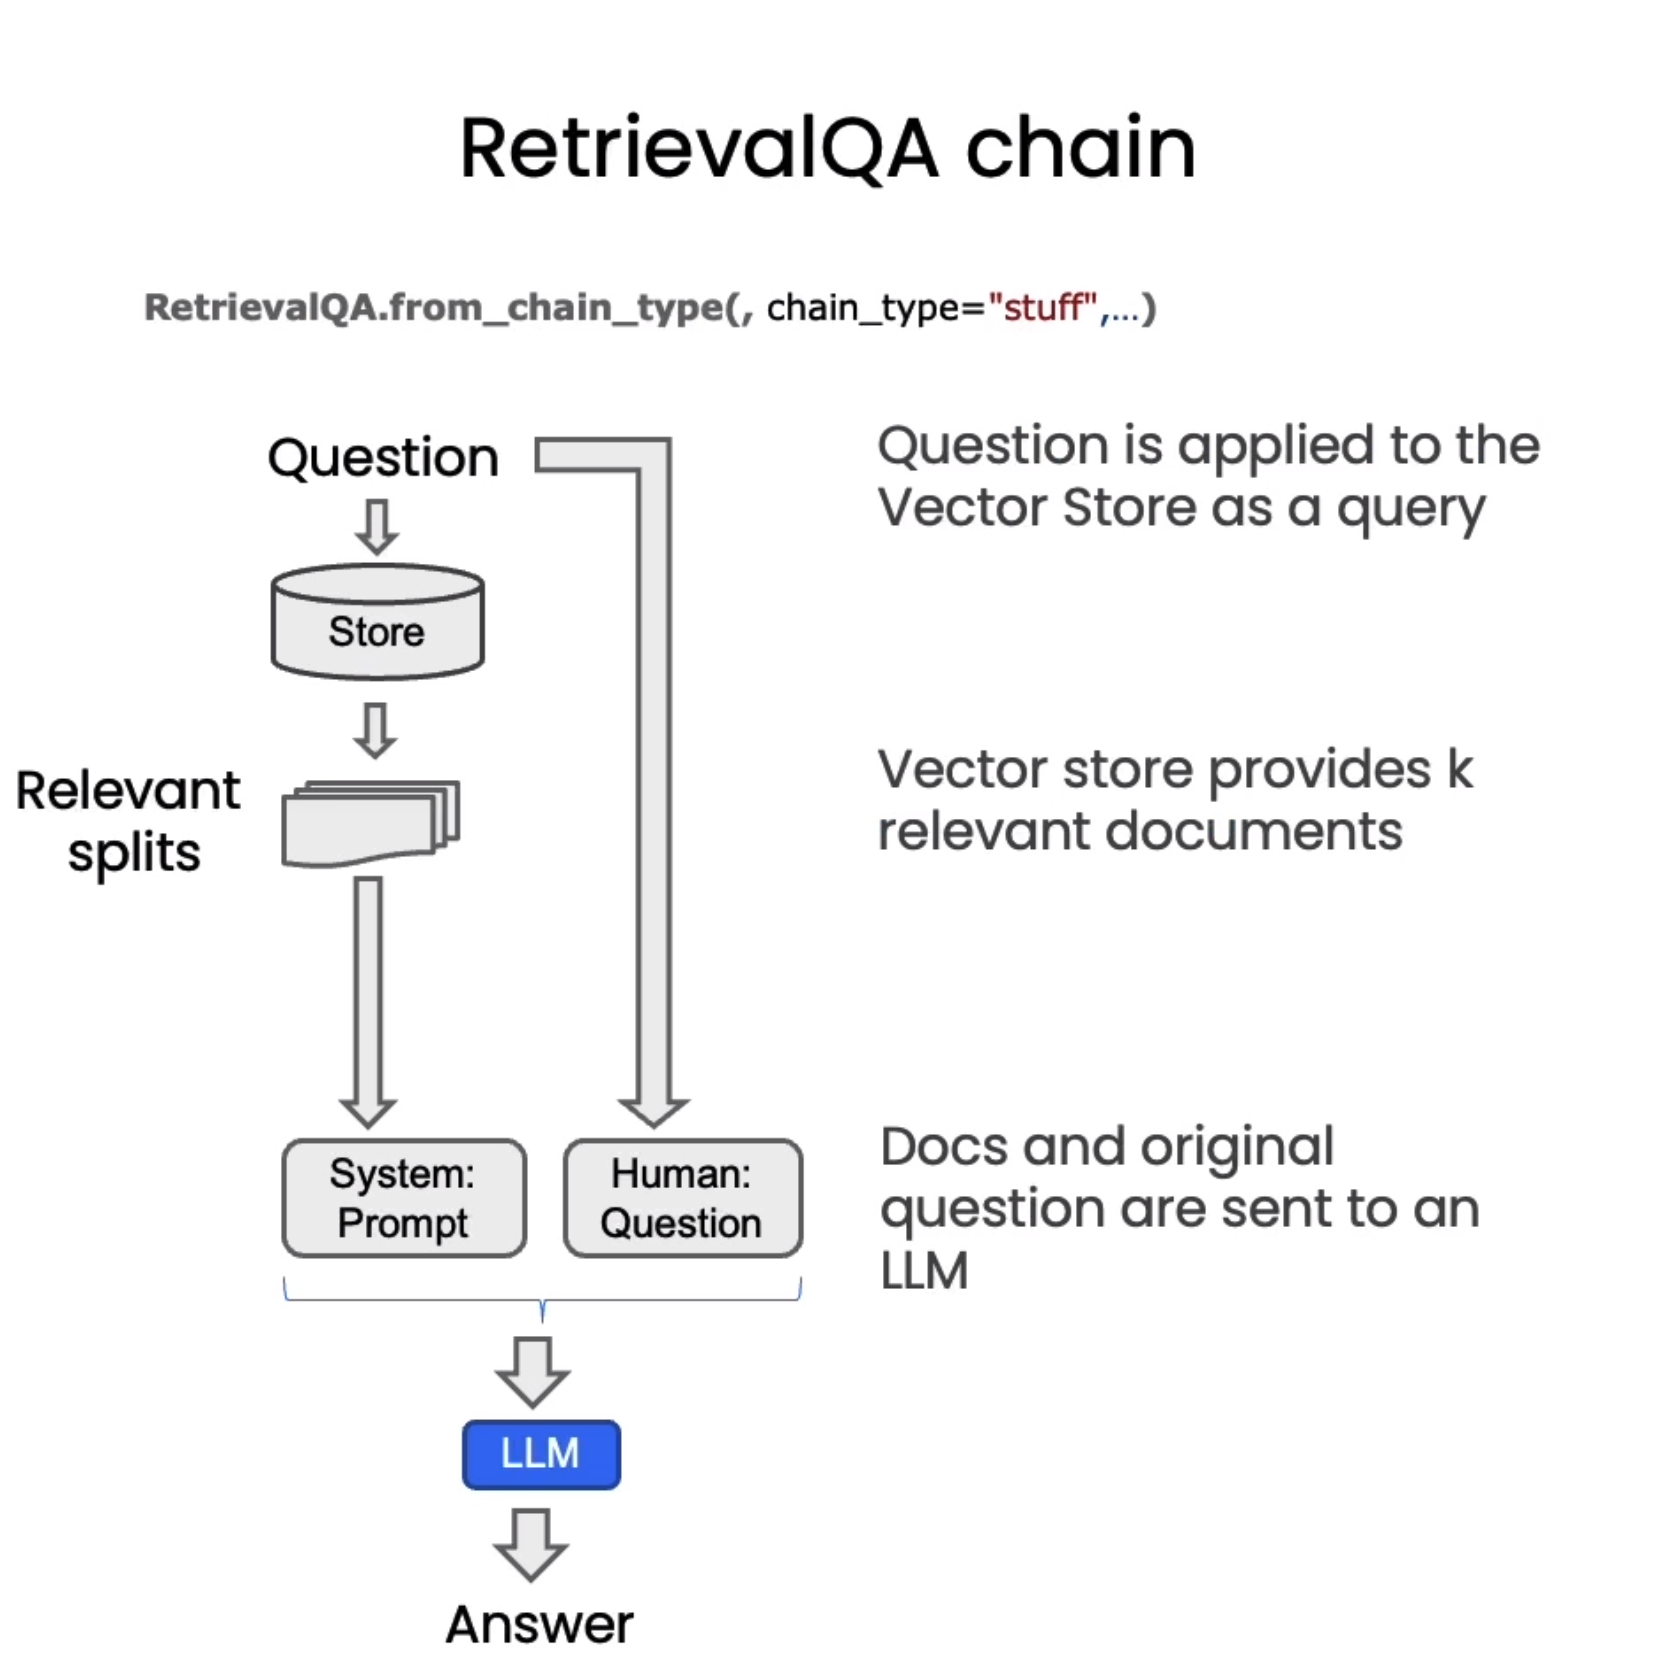

---

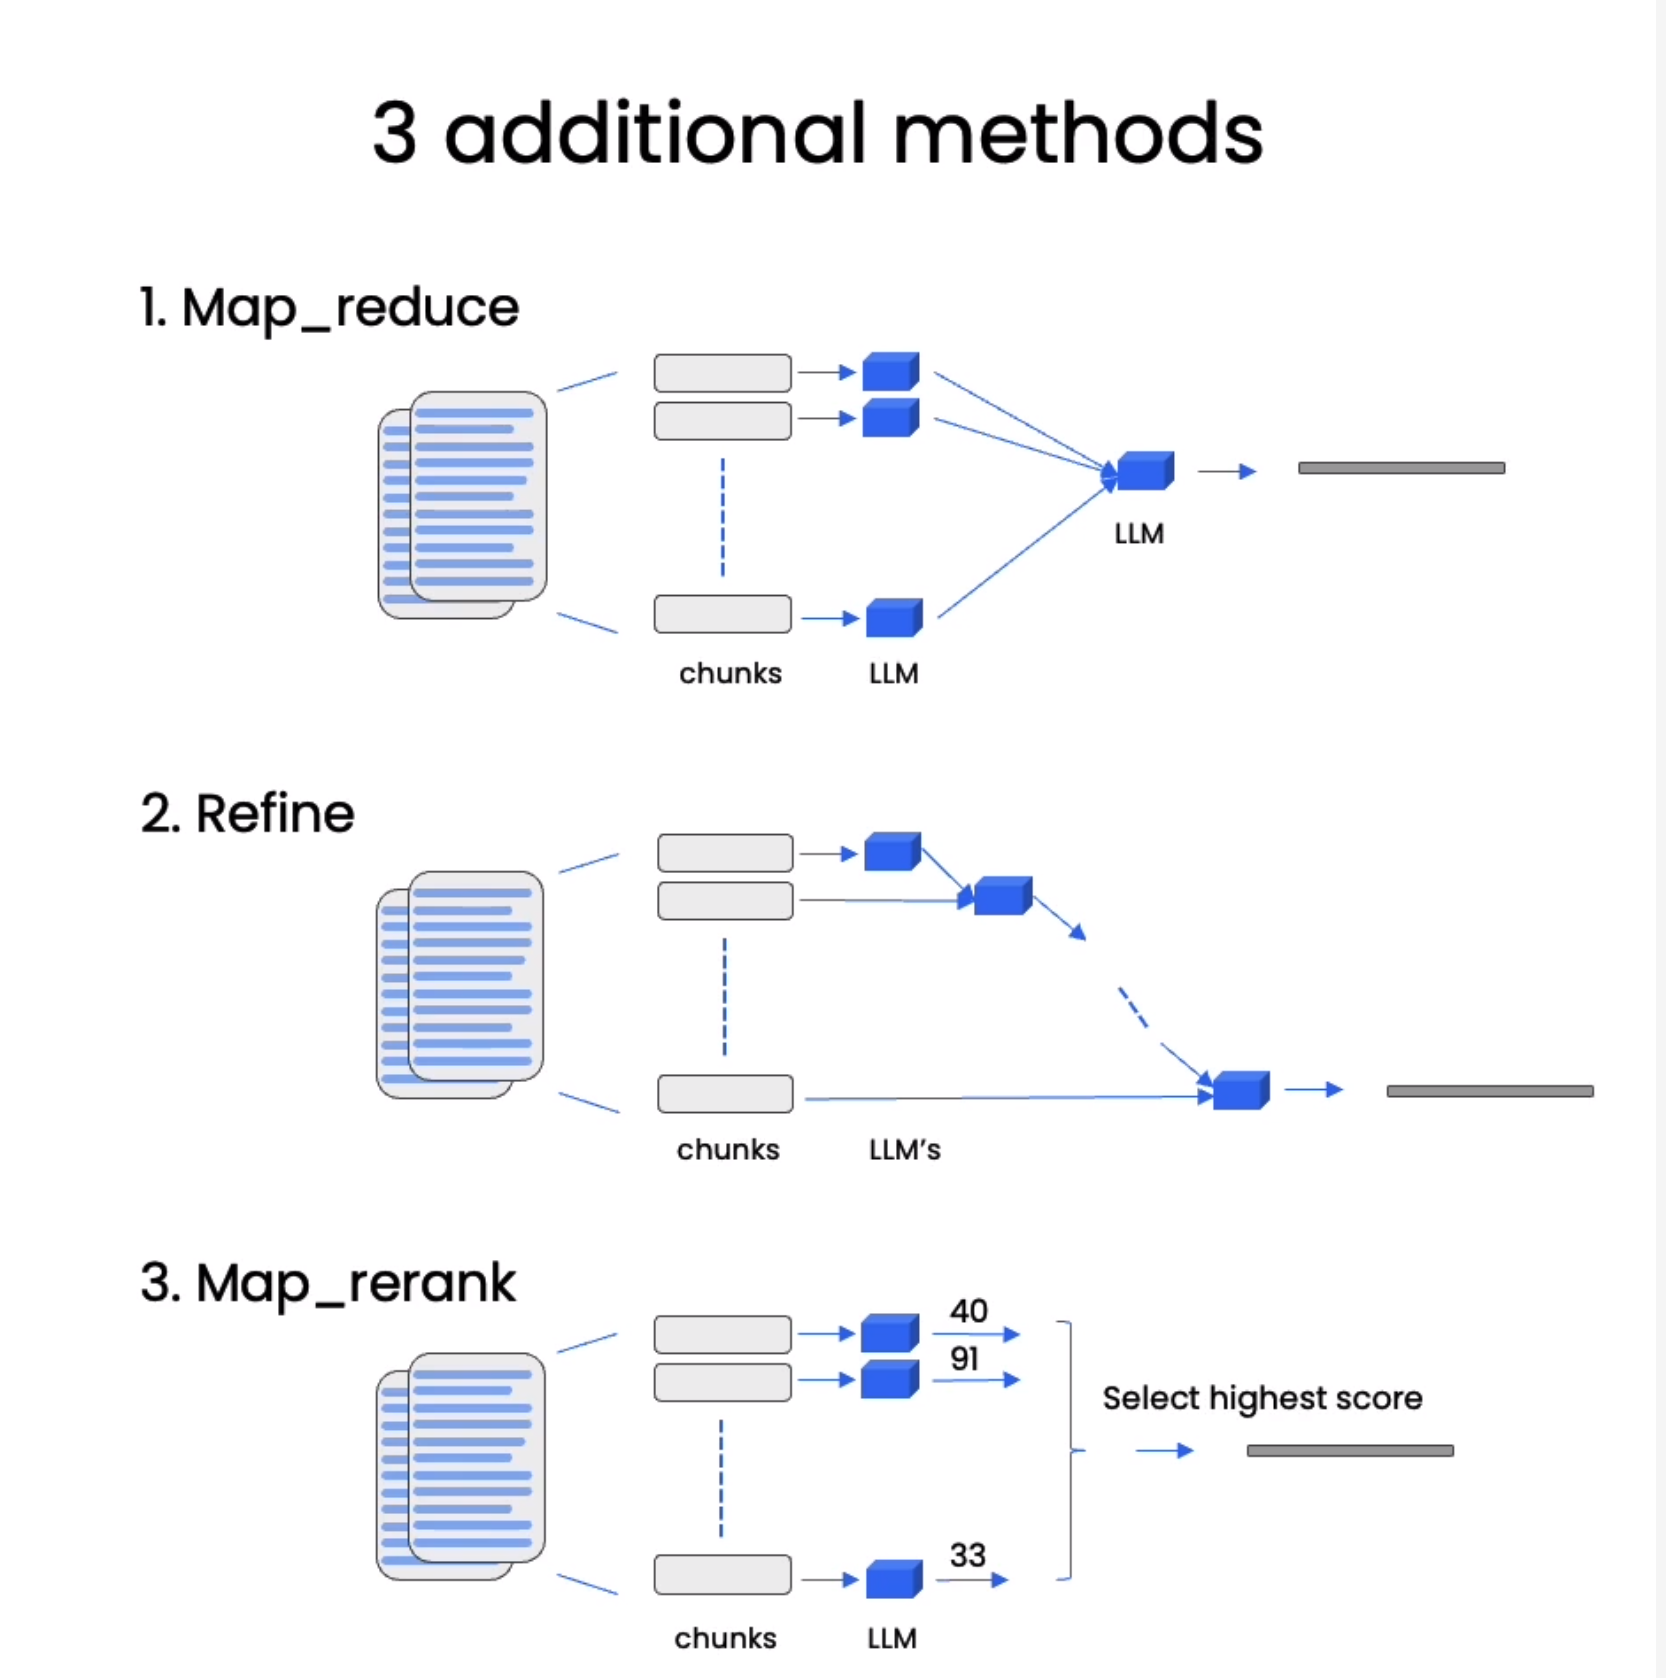

---

## Overview

Recall the overall workflow for retrieval augmented generation (RAG):

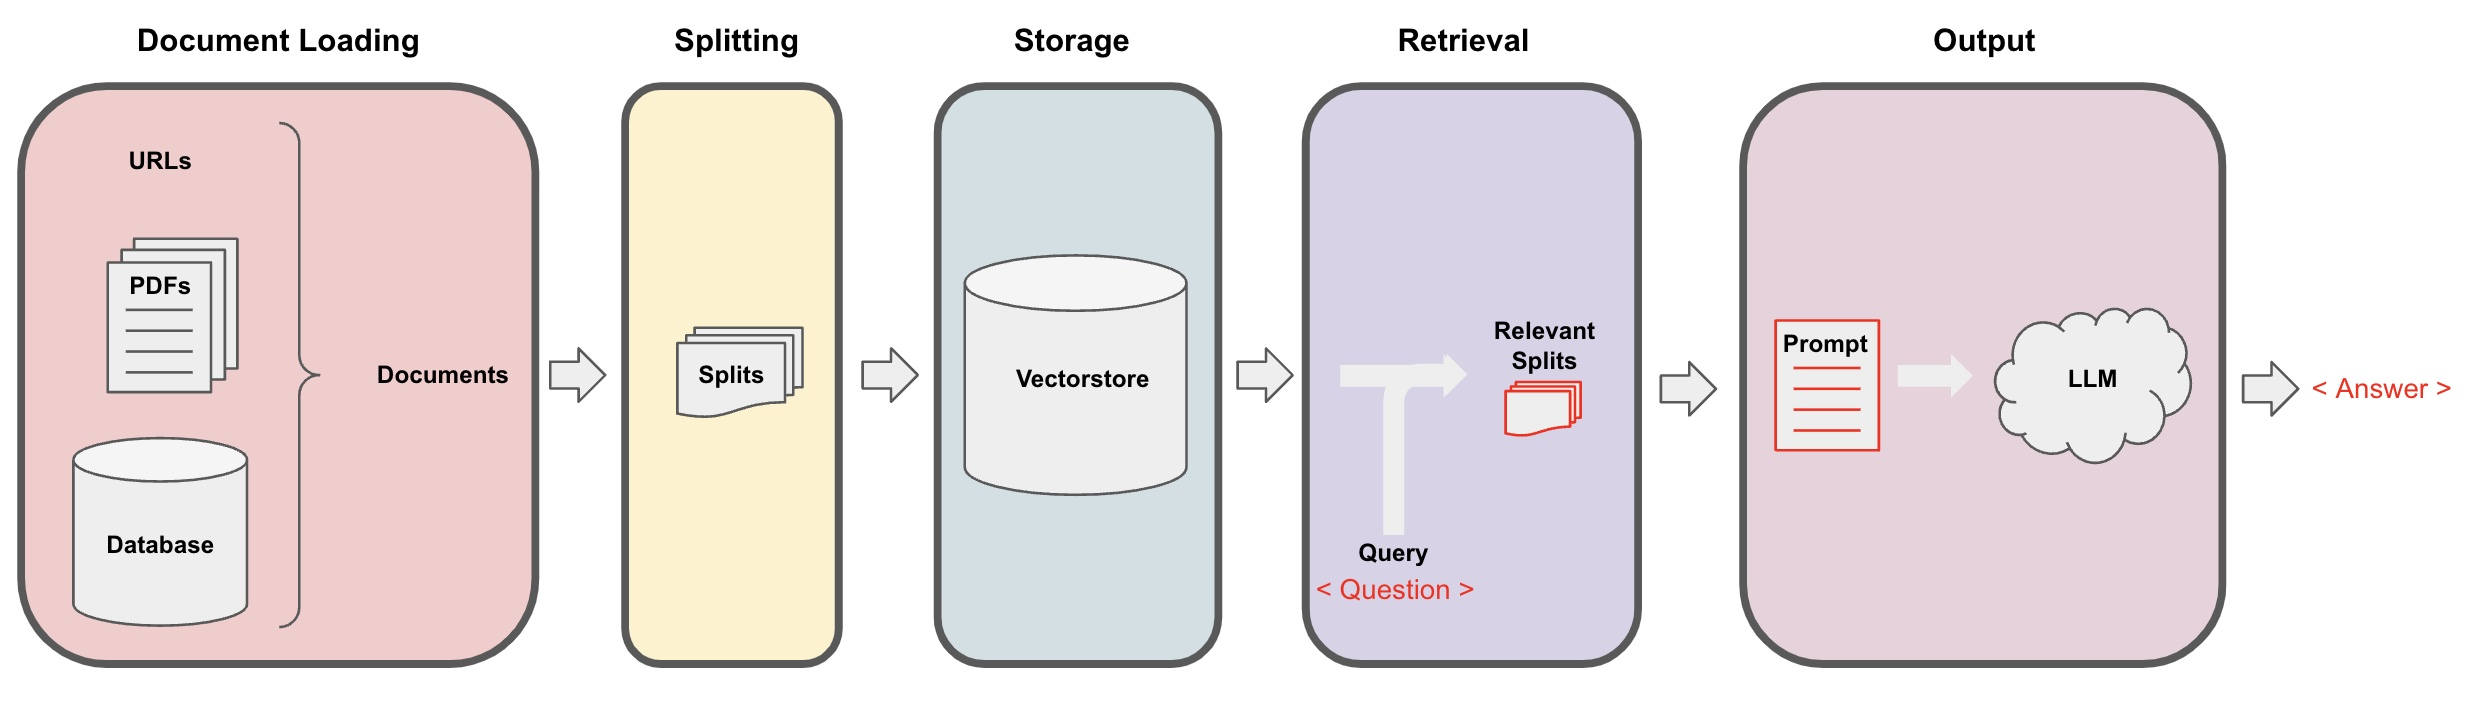

We discussed `Document Loading` and `Splitting` as well as `Storage` and `Retrieval`.

Let's load our vectorDB. 

In [1]:
import os
import openai
import sys
sys.path.append('../..')

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

openai.api_key  = os.environ['OPENAI_API_KEY']

The code below was added to assign the openai LLM version filmed until it is deprecated, currently in Sept 2023. 
LLM responses can often vary, but the responses may be significantly different when using a different model version.

In [2]:
import datetime
current_date = datetime.datetime.now().date()
if current_date < datetime.date(2023, 9, 2):
    llm_name = "gpt-3.5-turbo-0301"
else:
    llm_name = "gpt-3.5-turbo"
print(llm_name)

gpt-3.5-turbo


In [3]:
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings
persist_directory = 'docs/chroma/'
embedding = OpenAIEmbeddings()
vectordb = Chroma(persist_directory=persist_directory, embedding_function=embedding)

In [4]:
print(vectordb._collection.count())

209


In [5]:
question = "What are major topics for this class?"
docs = vectordb.similarity_search(question,k=3)
len(docs)

3

In [6]:
docs

[Document(page_content="statistics for a while or maybe algebra, we'll go over those in the discussion sections as a \nrefresher for those of you that want one.  \nLater in this quarter, we'll also use the disc ussion sections to go over extensions for the \nmaterial that I'm teaching in the main lectur es. So machine learning is a huge field, and \nthere are a few extensions that we really want  to teach but didn't have time in the main \nlectures for.", metadata={'source': 'docs/cs229_lectures/MachineLearning-Lecture01.pdf', 'page': 8}),
 Document(page_content="statistics for a while or maybe algebra, we'll go over those in the discussion sections as a \nrefresher for those of you that want one.  \nLater in this quarter, we'll also use the disc ussion sections to go over extensions for the \nmaterial that I'm teaching in the main lectur es. So machine learning is a huge field, and \nthere are a few extensions that we really want  to teach but didn't have time in the main \nlectures f

In [7]:
from langchain.chat_models import ChatOpenAI
llm = ChatOpenAI(model_name=llm_name, temperature=0)

### RetrievalQA chain
- uses stuff by default

In [8]:
from langchain.chains import RetrievalQA

In [9]:
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever()
)

In [10]:
result = qa_chain({"query": question})

In [11]:
result["result"]

'The major topics for this class are machine learning and its various extensions.'

### Prompt

In [12]:
from langchain.prompts import PromptTemplate

# Build prompt
template = """Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer. Use three sentences maximum. Keep the answer as concise as possible. Always say "thanks for asking!" at the end of the answer. 
{context}
Question: {question}
Helpful Answer:"""
QA_CHAIN_PROMPT = PromptTemplate.from_template(template)


In [13]:
# Run chain
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

In [14]:
question = "Is probability a class topic?"

In [15]:
result = qa_chain({"query": question})

In [16]:
result["result"]

'Yes, probability is a topic that will be covered in the class. Thanks for asking!'

In [17]:
result["source_documents"][0]

Document(page_content="of this class will not be very program ming intensive, although we will do some \nprogramming, mostly in either MATLAB or Octa ve. I'll say a bit more about that later.  \nI also assume familiarity with basic proba bility and statistics. So most undergraduate \nstatistics class, like Stat 116 taught here at Stanford, will be more than enough. I'm gonna \nassume all of you know what ra ndom variables are, that all of you know what expectation \nis, what a variance or a random variable is. And in case of some of you, it's been a while \nsince you've seen some of this material. At some of the discussion sections, we'll actually \ngo over some of the prerequisites, sort of as  a refresher course under prerequisite class. \nI'll say a bit more about that later as well.  \nLastly, I also assume familiarity with basi c linear algebra. And again, most undergraduate \nlinear algebra courses are more than enough. So if you've taken courses like Math 51, \n103, Math 113 or 

### RetrievalQA chain types

In [18]:
qa_chain_mr = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    chain_type="map_reduce"
)

In [19]:
result = qa_chain_mr({"query": question})

In [20]:
result

{'query': 'Is probability a class topic?',
 'result': 'Based on the provided information, it is not clear whether probability is a specific topic covered in the class.'}

In [21]:
result["result"]

'Based on the provided information, it is not clear whether probability is a specific topic covered in the class.'

If you wish to experiment on the `LangChain plus platform`:

 * Go to [langchain plus platform](https://www.langchain.plus/) and sign up
 * Create an API key from your account's settings
 * Use this API key in the code below   
 * uncomment the code  
 Note, the endpoint in the video differs from the one below. Use the one below.

In [22]:
#import os
#os.environ["LANGCHAIN_TRACING_V2"] = "true"
#os.environ["LANGCHAIN_ENDPOINT"] = "https://api.langchain.plus"
#os.environ["LANGCHAIN_API_KEY"] = "..." # replace dots with your api key

In [23]:
qa_chain_mr = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    chain_type="map_reduce"
)
result = qa_chain_mr({"query": question})
result["result"]

'Based on the provided information, it is not clear whether probability is a specific topic covered in the class.'

In [24]:
qa_chain_mr = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    chain_type="refine"
)
result = qa_chain_mr({"query": question})
result["result"]

'Based on the additional context provided, it is still not explicitly mentioned whether probability is a specific topic covered in the class. However, the instructor does mention going over statistics and algebra in the discussion sections as a refresher, which suggests that probability may be included as part of the statistics component. Additionally, the instructor mentions using the discussion sections to cover extensions for the material taught in the main lectures, so it is possible that probability could be discussed as an extension topic in relation to machine learning. Therefore, while probability is not explicitly confirmed as a class topic, it is likely to be covered to some extent within the broader context of statistics and machine learning.'

### RetrievalQA limitations
 
QA fails to preserve conversational history.
So we neeed to introduce memory.

In [25]:
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever()
)

In [26]:
question = "Is probability a class topic?"
result = qa_chain({"query": question})
result["result"]

'Yes, probability is a topic that will be covered in this class. The instructor assumes familiarity with basic probability and statistics, so it is expected that students have prior knowledge in this area.'

In [27]:
question = "why are those prerequesites needed?"
result = qa_chain({"query": question})
result["result"]

'The prerequisites for the class are needed because the instructor assumes that all students have a basic knowledge of computer science and basic computer skills and principles. This is important because the class will cover advanced topics in machine learning that build upon these foundational concepts. Understanding topics like big-O notation and basic computer skills will be necessary for comprehending and applying the machine learning algorithms taught in the class.'

Note, The LLM response varies. Some responses **do** include a reference to probability which might be gleaned from referenced documents. The point is simply that the model does not have access to past questions or answers, this will be covered in the next section.